Notebook adapted from prediction_lr.ipynb

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import pickle

from prediction_tools import error_analysis, get_youden_threshold, \
    plot_confusion_matrix, plot_prc, plot_roc, print_metrics, print_params
from random import sample, seed
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

seed(60611)

# Fixing hidden layer sizes to (9) seems to maximize the f1-score. When
# given a range of combinations to search through (e.g.
# [(a, b) for a in range(8,13) for b in range(4,7)]), GridSearchCV
# tends to make a poor choice.
param_grid = {
    'hidden_layer_sizes': [(9)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'adam'],
    'alpha': np.logspace(-5, 4, 10),
    'max_iter': [3000],
    'random_state': [60611],
}

clf = GridSearchCV(MLPClassifier(), param_grid, scoring='roc_auc', cv=4, n_jobs=-1)

# Read in data

In [2]:
X_train = pd.read_csv('train_data.csv') \
            .set_index(['subject_id', 'hadm_id', 'icustay_id'])

# Randomly downsample non-hyperchloremics in the training set
non_hyperchloremics = X_train.index[X_train['chl_110'] == 0].tolist()
X_train = X_train.drop(sample(non_hyperchloremics, int(0.9*len(non_hyperchloremics))))

y_train_chl_110 = X_train['chl_110'].tolist()
X_train = X_train.drop(columns=['chloride_max', 'chl_110'])  # drop 'cluster'

X_test = pd.read_csv('test_data.csv') \
           .set_index(['subject_id', 'hadm_id', 'icustay_id'])
y_test_chl_110 = X_test['chl_110'].tolist()
X_test = X_test.drop(columns=['chloride_max', 'chl_110'])  # drop 'cluster'

print "%d features, %d training rows (%.2f%% hyperchloremic), %s test rows" % \
      (len(X_train.columns),
       len(X_train),
       100*float(sum(y_train_chl_110))/len(X_train),
       len(X_test))

36 features, 3559 training rows (38.27% hyperchloremic), 9999 test rows


# Whole dataset

Selected parameters:
- solver: adam
- activation: logistic
- max_iter: 3000
- random_state: 60611
- alpha: 0.1
- hidden_layer_sizes: 9


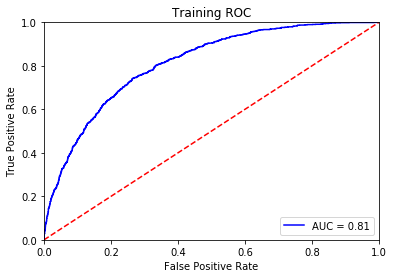

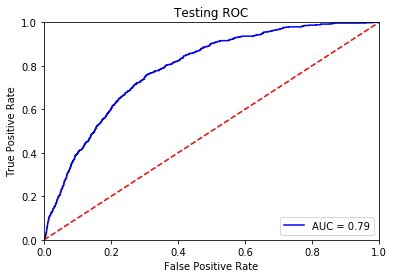

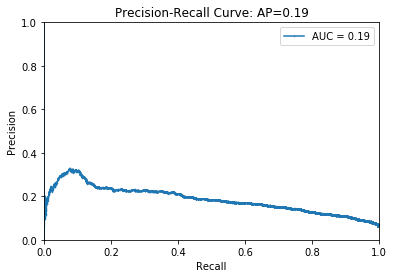

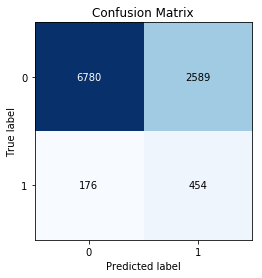

Precision:  0.1491948734801183
Recall   :  0.7206349206349206
F-measure:  0.24720936564116527


In [3]:
clf.fit(X_train, y_train_chl_110)
print_params(clf, param_grid.keys())

train_probabilities = clf.predict_proba(X_train)[:,1]
youden_threshold = get_youden_threshold(y_train_chl_110, train_probabilities)
plot_roc(y_train_chl_110, train_probabilities, "Training ROC")

test_probabilities = clf.predict_proba(X_test)[:,1]
test_predictions = ((test_probabilities - youden_threshold) >= 0).astype(int)
plot_roc(y_test_chl_110, test_probabilities, "Testing ROC")
plot_prc(y_test_chl_110, test_probabilities)
print_metrics(y_test_chl_110, test_predictions)

# Error analysis

In [ ]:
with open("./error_analysis/scaler.pickle", 'rb') as f:
    to_standardize, scaler = pickle.load(f)

# It looks like the scaler has some precision problems when scaling
# back values of 0, so round to six decimals to address this.
X_train[to_standardize] = scaler.inverse_transform(X_train[to_standardize]).round(6)

error_analysis(X_train, y_train_chl_110, train_probabilities)

# Pickle for combined plotting

In [5]:
with open('./pickle/mlp_whole.pickle', 'wb') as f:
    pickle.dump(("Multi-layer Perceptron", y_test_chl_110, test_probabilities), f)